In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix, AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.likelihood import get_dh, get_hh
import tools.likelihood as likelihood

from tools.time_freq_likelihood import TimeFreqLikelihood

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [2]:
Tobs = YRSID_SI
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

f_ref = 0.0
phi_ref = 0.0
m1 = 9e5
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 10e3 * PC_SI * 1e6  # 3e3 in Mpc
inc = np.pi/3
beta = np.pi/4.
lam = np.pi/5.
psi = np.pi/6.
t_ref = 0.5 * YRSID_SI  # in the SSB reference frame

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

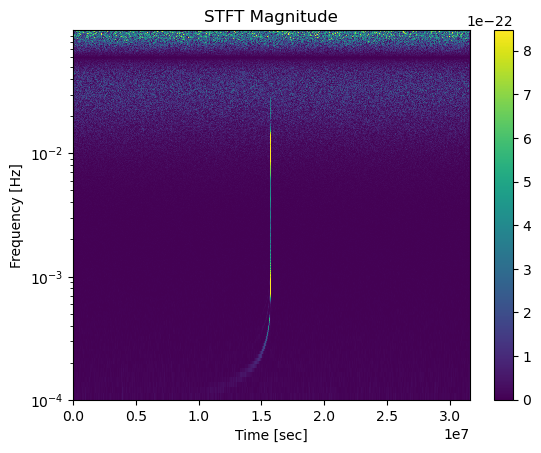

In [10]:
sim.plot_time_frequency()

In [3]:
print(sim.SNR_optimal())
print(likelihood.template_snr(data_f, sim.signal_f, AE1SensitivityMatrix(f_array), df=sim.df))

[3429.3386141]
3429.4901252230406


In [4]:
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, dt=dt)
analysis.get_stft_of_data()

In [5]:
analysis.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
)

np.float64(-147.2961261035974)

In [8]:
analysis.calculate_time_frequency_likelihood(
    m1 *20* (1 + 1e-7 * np.random.randn(1))[0],
    m2 * (1 + 1e-7 * np.random.randn(1))[0], 
    a1,
    a2,
    dist , 
    phi_ref * (1 + 1e-7 * np.random.randn(1))[0],
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref * (1 + 1e-7 * np.random.randn(1))[0],
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
)#/analysis.dt

np.float64(-3303.999977057596)

In [ ]:
analysis_2 = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen, dt=dt)
analysis_2.get_stft_of_data()
analysis_2.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
)

np.float64(0.0)

In [7]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [8]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_time_frequency_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
    )
    return ll

In [ ]:
# clear (for internal clearing of answers)
 
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(9e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    a1,
    a2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [10]:
# x[None] adds a new dimension at the front: It’s a standard trick to reshape arrays for broadcasting or stacking purposes.
 
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)

array([[-34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674],
       [-34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34.28315674, -34.28315674,
        -34.28315674, -34.28315674, -34

In [ ]:
sampler.run_mcmc(start_state, 10, progress=True)

In [ ]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "lam", "beta"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "lam": injection_params_sub[2], "beta": injection_params_sub[3]}))
fig = c.plotter.plot()